# DRSA

This notebook implements the DRSA survival model for Heart Failure patients (with functional covariates).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from lifelines.utils import concordance_index
from tqdm import tqdm

from utils.drsa_utils import *
from utils.common import *

In [2]:
# load data
df = pd.read_csv('../../data/main_process_preprocessed_data.csv')
test = pd.read_csv('../../data/main_process_preprocessed_data_test.csv')

In [3]:
# use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Prepare data

In [4]:
# set time windows parameters
T_max = 365*10
n_times = int(T_max/60)
# discretise time
df['discretised_time_event'] = [int(v) for v in df.time_event/T_max*n_times]
times = np.arange(n_times).reshape(-1,1,1)

print('(Arbitrary) maximum survival time:',np.round(T_max/365,1),'years')
print('Number of time steps:',n_times)
print('Size time step:',np.round(T_max/n_times/30,1),'months')

(Arbitrary) maximum survival time: 10.0 years
Number of time steps: 60
Size time step: 2.0 months


In [5]:
# create dummy sex
df['sexM'] = [1 if v == 'M' else 0 for v in df.sex]
test['sexM'] = [1 if v == 'M' else 0 for v in test.sex]

In [6]:
# set features
features = ['sexM', 'age_in','ACE_PC1', 'ACE_PC2','beta_PC1', 'beta_PC2','hospitalisation_PC1', 'hospitalisation_PC2']

X,X_test = df[features],test[features]
y = df.discretised_time_event
true_times = df.time_event
status = df.status

In [7]:
# scale
mean = X.mean()
std = X.std()
X -= mean
X /= std
X_test -= mean
X_test /= std

In [8]:
# split train in train/validation (for early stopping)
X_train, X_valid, y_train, y_valid, status_train, status_valid = \
    train_test_split(X, y, status, test_size=0.05, random_state=47)

In [9]:
X_train.shape,X_valid.shape,X_test.shape

((3020, 8), (159, 8), (1362, 8))

## Reformat datasets for lstm layers

In [10]:
# Reformat datasets for lstm layers (3 dimensions: time,id,features)
x_training = reformat_dataset(X_train,times)
x_validation = reformat_dataset(X_valid,times)
x_test = reformat_dataset(X_test,times)

In [11]:
# dimensions: time,id,features (added time)
x_training.shape, x_validation.shape, x_test.shape

((60, 3020, 9), (60, 159, 9), (60, 1362, 9))

In [12]:
# transform validation sets in torch tensors
X_valid = torch.from_numpy(x_validation.astype('float32'))
y_valid = torch.from_numpy(y_valid.values)
status_valid = torch.from_numpy(status_valid.values.astype('float32'))
X_valid,y_valid,status_valid = X_valid.to(device),y_valid.to(device),status_valid.to(device)

# transform test set in tensors
X_test = torch.from_numpy(x_test.astype('float32'))
X_test = X_test.to(device)

## Prepare for training

In [13]:
# set early stopping parameter
max_epochs_no_improvement = 20

# build a training data loader
trainds= SequenceDataset(x_training, y_train,status_train) 
params = {'batch_size': 25,
          'shuffle': True,
          'num_workers': 4}
 
train_dl = DataLoader(trainds, **params)

## Train

In [14]:
# set criterion
criterion = DRSA_Loss(0.75)
# build the network
net = DRSA(len(features)+1).to(device)
# set optimizer
optimizer = optim.Adam(net.parameters(), lr=5e-5)

In [16]:
train_losses,valid_losses = [],[]
best_net = DRSA(len(features)+1).to(device)
best_loss = 1e10
epochs_no_improvement = 0

#train
for epoch in range(500):  # loop over the dataset multiple times
    running_loss = 0.0
    
    net.train()
    for i, data in enumerate(train_dl, 0):
        inputs, labels, status = data
        # dimensions: time, id, features
        inputs = inputs.transpose(0,1)
        # make it use GPU, if you have it
        inputs, labels, status = inputs.to(device), labels.to(device), status.to(device) 
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize (rows: id; columns: time)
        outputs = net(inputs).reshape(n_times,-1).transpose(0,1)
        loss = criterion(outputs, labels,status)
        loss.backward()
        optimizer.step()
        # training loss
        running_loss += loss.item()
    
    # Evaluate on validation set
    net.eval()
    valid_pred = net(X_valid).reshape(n_times,-1).transpose(0,1)
    valid_loss = criterion(valid_pred, y_valid,status_valid).item()
    
    # store losses
    train_losses.append(running_loss)
    valid_losses.append(valid_loss)
    
    # save best weights
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_net.load_state_dict(net.state_dict())
        epochs_no_improvement = 0
    else:
        epochs_no_improvement += 1
       
    # early stopping
    if epochs_no_improvement > max_epochs_no_improvement:
        break
    
    if epoch % 25 == 0:
        print('Epoch: ',epoch,'   Training Loss: ',np.round(running_loss,2),'   Current Validation Loss: ',np.round(valid_loss,2),'   Best Validation Loss: ',np.round(best_loss,2))

        
print('Finished Training')

Epoch:  0    Training Loss:  13234.48    Current Validation Loss:  621.4    Best Validation Loss:  621.4
Epoch:  25    Training Loss:  9697.88    Current Validation Loss:  307.15    Best Validation Loss:  303.03
Epoch:  50    Training Loss:  9578.76    Current Validation Loss:  293.19    Best Validation Loss:  288.54
Epoch:  75    Training Loss:  9610.26    Current Validation Loss:  292.49    Best Validation Loss:  282.87
Epoch:  100    Training Loss:  9506.12    Current Validation Loss:  290.21    Best Validation Loss:  282.07
Epoch:  125    Training Loss:  9480.72    Current Validation Loss:  284.24    Best Validation Loss:  281.84
Finished Training


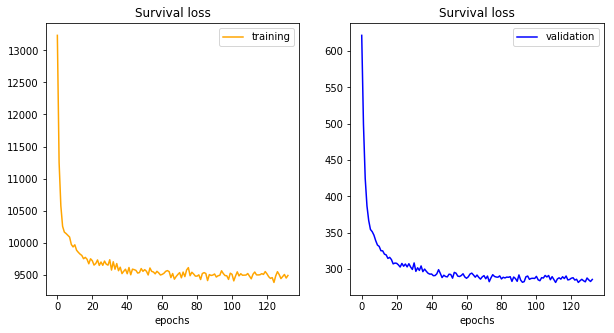

In [17]:
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
plt.plot(train_losses, color = 'orange', label = 'training')
plt.legend()
plt.title('Survival loss')
plt.xlabel('epochs')

plt.subplot(1,2,2)
plt.plot(valid_losses, color = 'blue', label = 'validation')
plt.legend()
plt.title('Survival loss')
plt.xlabel('epochs')

plt.show()

# Evaluate Concordance Index on test set

Note: we convert predictions to original time scale and we compare them with true time of events; this is done in order to make it comparable with other models

In [18]:
best_net.eval()
# predict hazards
predictions_test_set = best_net(X_test).reshape(n_times,-1).transpose(0,1)
# compute survival time probabilities from hazards
survival_density = get_survival_density(predictions_test_set)
# compute expected survival times in the original scale
expected_survival_times = compute_expected_survival_time(survival_density,n_times,T_max)

In [21]:
# evaluate C-index
C = concordance_index(test.time_event,expected_survival_times,test.status)
print('Concordance Index on test set:',np.round(C*100,2),'%')

Concordance Index on test set: 68.71 %


In [23]:
# save model
torch.save(best_net.state_dict(), '../../data/DRSA_weights.pt')
# save predictions
pd.DataFrame(expected_survival_times).to_csv('../../data/predictions_DRSA.csv',index= False)